# Portfolio calculations using CAC40 data

[Markowitz portfolio](#markowitz)
- [Annualized return](#r_ann)
- [Annualized volatility](#vol_ann)
- [Sharpe ratio](#sharpe)
- [Covariance matrix](#cov)
- [Efficient frontier](#frontier)

[Maximum Sharpe ratio portfolio](#msr)

[Global Minimum Variance portfolio](#gmv)

[Backtests](#backtest)

In [1]:
%load_ext autoreload
%autoreload 2

from finance_utils import annualize_rets, portfolio_return, portfolio_vol

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

---

In [12]:
df_cac40 = pd.read_pickle('./cac40_data/df_cac40.pkl')
df_cac40_rets = df_cac40.pct_change().dropna() # drop 1st line containing NaNs

df_cac40_stocks = pd.read_pickle('./cac40_data/df_cac40_stocks.pkl')
df_cac40_stocks_rets = df_cac40_stocks.pct_change().dropna()

# annualized data
rets = annualize_rets(df_cac40_stocks_rets, 252)
cov = df_cac40_stocks_rets.cov()

---

## Markowitz portfolio  <a id='markowitz'></a>

Considering returns are known, the Markowitz portfolio weights are given by minimizing portfolio volatility for any value of portfolio return.

$$\textbf{w} = \arg\min_w \frac{1}{2}\textbf{w}^T\Sigma\textbf{w}$$
subject to: $\textbf{w}^T.\textbf{r}=r_{\text{portfolio}}$, $\textbf{w}^T.\textbf{1}=1$, $w>0$ (no shorting). $\Sigma$ is the covariance matrix, and the 1/2 factor is added in order to have a quadratic form.

$\textbf{r}$ is the vector of annualized returns and $r_{\text{portfolio}}$ is the portfolio return.

### Efficient frontier  <a id='frontier'></a>

Considering returns are known, the Markowitz portfolio weights are given by minimizing portfolio volatility for any value of portfolio return.

$$\textbf{w} = \arg\min_w \frac{1}{2}\textbf{w}^T\Sigma\textbf{w}$$
subject to: $\textbf{w}^T.\textbf{r}=\textbf{r}_0$, $\textbf{w}^T.\textbf{1}=1$, $w>0$ (no shorting). $\Sigma$ is the covariance matrix, and the 1/2 factor is added in order to have a quadratic form.

##### Minimize volatility

Find the set of weights that minimize the output of the `portfolio_vol(weights, cov)`

In [4]:
def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # each of the n weights is in [0.0; 1.0]
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x


Weights minimizing the variance for a return of 0.15, given historical returns and covariance

In [5]:
minimize_vol(0.15, rets, cov)

array([3.23313502e-02, 8.78881386e-18, 9.32413868e-18, 0.00000000e+00,
       2.79182059e-18, 7.48099499e-18, 0.00000000e+00, 0.00000000e+00,
       4.87199825e-02, 0.00000000e+00, 1.01372903e-17, 0.00000000e+00,
       2.65043864e-02, 9.62229428e-19, 0.00000000e+00, 1.16760812e-01,
       0.00000000e+00, 0.00000000e+00, 1.26736805e-02, 2.08031292e-18,
       0.00000000e+00, 3.91943259e-01, 0.00000000e+00, 1.30104261e-18,
       9.60196549e-18, 0.00000000e+00, 0.00000000e+00, 1.07842026e-01,
       2.43945489e-18, 0.00000000e+00, 6.23416249e-19, 0.00000000e+00,
       0.00000000e+00, 1.85302400e-01, 7.79221041e-02, 0.00000000e+00,
       1.61275073e-18, 8.94466792e-19, 0.00000000e+00, 4.74338450e-18])

##### Plot efficient frontier

Spanning `n_points` equally spaced returns accross all returns values in expected returns `er`, minimize the volatility using Markowitz portfolio calculation `minimize_vol()`

In [6]:
def optimal_weights(n_points, er, cov):
    """
    Find optimal weights for a given set of returns and a covariance matrix
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')


<Axes: xlabel='Volatility'>

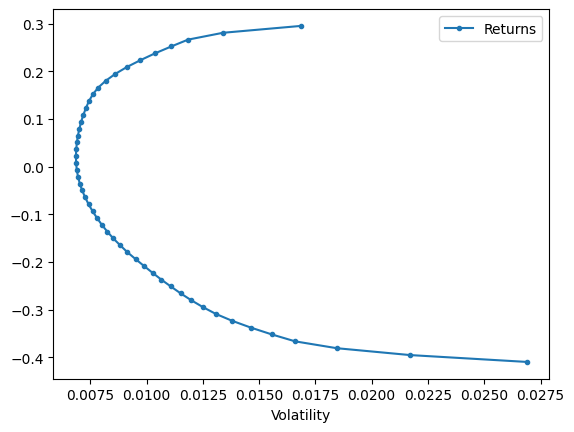

In [7]:
plot_ef(50, rets, cov)

## Maximum Sharpe ratio portfolio <a id='msr'></a>

Portfolio Sharpe ratio measures return over risk using annualized quantities:
$$\lambda=\frac{r_{portfolio} - r_{riskfree}}{\sigma_{portfolio}}$$ 

Writing $\textbf{r}$ as the vector of annualized returns for each assets, $\textbf{w}$ the vector of weights for each asset, and $\Sigma$ the covariace matrix, we have:

$$r_{portfolio}=\textbf{w}^T.\textbf{r}$$
$$\sigma_{portfolio}=\sqrt{\textbf{w}^T\Sigma\textbf{w}}$$

The **maximum Sharpe ratio portfolio** is given by the set of weights $\textbf{w}$ that minimize $-\lambda$.

In [8]:
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    
    er = annualized returns for each asset of the portfolio
    cov = covariance matrix between the returns of each asset
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # each of the n weights is in [0.0; 1.0]
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    # minimize the negative Sharpe ratio
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


Plotting the MSR portfolio on the efficient frontier

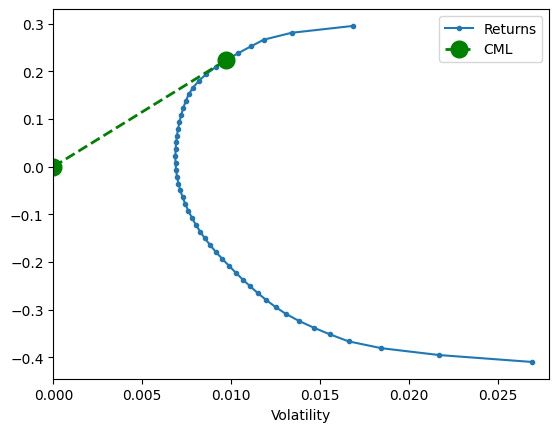

In [10]:
# plot EF
ax = plot_ef(50, rets, cov)
ax.set_xlim(left = 0)
# get MSR
rf = 0.0
w_msr = msr(rf, rets, cov)
r_msr = portfolio_return(w_msr, rets)
vol_msr = portfolio_vol(w_msr, cov)
# add Capital Market Line
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12, label = 'CML')
ax.legend()

## Global Minimum Variance portfolio <a id='gmv'></a>


GMV is the portfolio of lowest volatility on the efficient frontier.

GMV is calculated by using the optimizer of the max Sharpe ratio portfolio, where all weights are set equal. 

=> The optimizer cannot improve the sharpe ratio through raising returns, and so it must do so by lowering volatility

In [37]:
def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    # parameters of msr:
    # riskfree_rate = 0 bacause it's not going to get used anyway
    # weights = np.repeat(1,n) : put equal weights everywhere so that optimization is done only on the cov matrix
    return msr(0, np.repeat(1, n), cov)

In [38]:
gmv(cov)

array([1.08424115e-11, 4.83878568e-10, 3.33760694e-10, 1.62164247e-10,
       7.14023528e-11, 2.67507270e-10, 2.20426004e-02, 1.27457883e-11,
       2.90670115e-02, 8.92060359e-11, 7.07960641e-02, 4.30486655e-02,
       2.11593555e-11, 1.72824729e-11, 4.73447136e-02, 3.41055932e-11,
       2.32394142e-11, 2.85288113e-11, 3.95452485e-02, 1.18815122e-11,
       8.80965379e-11, 3.76954029e-01, 3.21054540e-02, 4.94384488e-11,
       1.77578186e-10, 2.21455514e-10, 2.21221836e-10, 7.80868017e-02,
       6.51368443e-12, 3.92884277e-10, 3.39377127e-10, 1.40073303e-11,
       1.66042908e-02, 1.08290316e-01, 2.48102112e-02, 3.06234506e-02,
       4.00088048e-10, 1.06152535e-10, 8.06811410e-02, 5.13860795e-12])

## Backtests<a id='backtest'></a>

In [15]:
start_value = df_cac40.loc['2021-09-20'].values[0]

<Axes: >

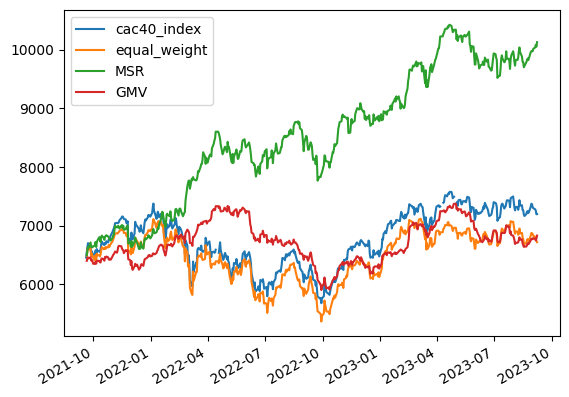

In [28]:
equal_weights = pd.DataFrame(start_value*(1+((1/40)*df_cac40_stocks_rets).sum(axis=1)).cumprod())
equal_weights.columns = ['equal_weight'] #equal weights 1/40 everywhere
msr_weights = pd.DataFrame(start_value*(1+(w_msr*df_cac40_stocks_rets).sum(axis=1)).cumprod())
msr_weights.columns = ['MSR'] # MSR
gmv_weights = pd.DataFrame(start_value*(1+(w_gmv*df_cac40_stocks_rets).sum(axis=1)).cumprod())
gmv_weights.columns = ['GMV'] # MSR
pd.concat([df_cac40.loc['2021-09-20':], equal_weights, msr_weights, gmv_weights], axis=1).plot()

The MSR portfolio is highly concentrated in 3 assets (Total, Hermès, Thales)

In [18]:
w_msr

array([0.00000000e+00, 1.21519352e-12, 9.22982778e-12, 9.06529370e-12,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.06961533e-12,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.59111436e-12,
       0.00000000e+00, 0.00000000e+00, 1.14110937e-11, 1.77865947e-01,
       1.17604484e-11, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.89606614e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00046202e-13, 2.49060627e-02,
       0.00000000e+00, 0.00000000e+00, 1.41791306e-12, 0.00000000e+00,
       2.23995463e-11, 3.84876569e-01, 2.22744806e-01, 7.24969937e-12,
       3.14822615e-13, 0.00000000e+00, 6.36616839e-12, 2.52010464e-11])

These assets exhibited strong growth during the period of interest

In [39]:
rets[['RMS.PA','HO.PA','TTE.PA']]

RMS.PA    0.204878
HO.PA     0.295699
TTE.PA    0.254482
dtype: float64

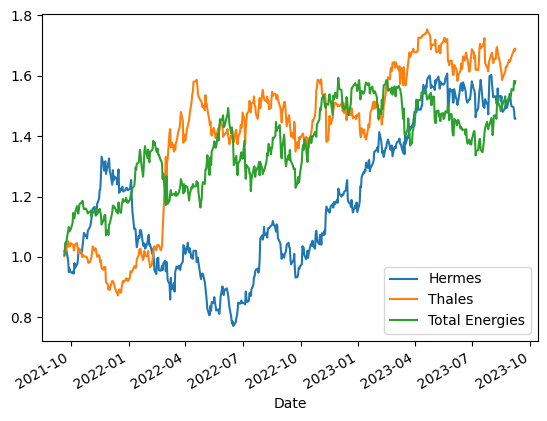

In [40]:
ax = (1+df_cac40_stocks_rets['RMS.PA']).cumprod().plot(label = 'Hermes')
# high jump after Ukraine invasion for weapon maker Thales
ax = (1+df_cac40_stocks_rets['HO.PA']).cumprod().plot(label = 'Thales') 
ax = (1+df_cac40_stocks_rets['TTE.PA']).cumprod().plot(label = 'Total Energies')
ax.legend()

More general function for testing weighting schemes

In [134]:
def weight_ew(r):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def backtest_ws(r, estimation_window=60, weighting=weight_ew):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", 
    and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # ex: [(0, 60), (1, 61), ...]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # DataFrame containing weights for each asset at all dates
    weights = [weighting(r.iloc[win[0]:win[1]]) for win in windows]
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # returns = weighted sum of returs accross all assets
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

Testing `backtest_ws()` function

In [106]:
# manual construction of weighted portfolio wealth index as done a few cells above
ew_init_val = equal_weights['equal_weight'].values[0]
equal_weights = pd.DataFrame((1+((1/40)*df_cac40_stocks_rets).sum(axis=1)).cumprod())
equal_weights.columns = ['equal_weight'] #equal weights 1/40 everywhere

# using backtesting function
ewr =backtest_ws(df_cac40_stocks_rets, estimation_window=1, weighting=weight_ew)
ewi = (1+ewr).cumprod()

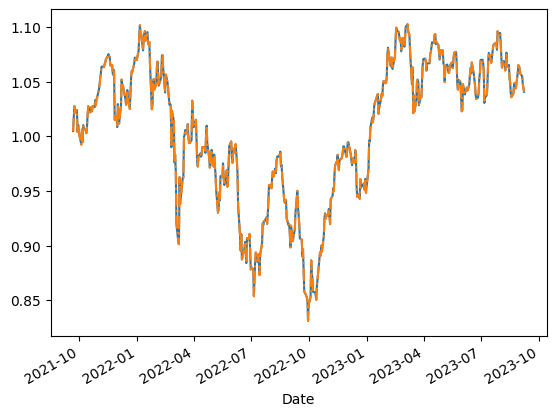

In [123]:
ax=ewi.plot()
ax=equal_weights['equal_weight'].plot(linestyle='-.')